In [2]:
import pandas as pd
import numpy as np

import datetime as dt

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from pandas import Series
from statsmodels.tsa.stattools import adfuller

C:\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
print(pd.__version__)
print(np.__version__)

0.23.4
1.15.4


# Analiza podataka

In [4]:
def plot_values_through_years(df, date_column, value_column):
    """Plots the values from dataframe.

    Parameters
    ----------
    df : DataFrame
        DataFrame with date and value columns
    date_column : str
        name of the column with dates
    value_column : str
        name of the column with numeric values

    Returns
    -------
    NoneType
        Method does not return nothing
    """
    year_list = df[date_column].dt.year.unique()

    counter = 1
    
    for year in year_list:
        df_period = df[df[date_column].dt.year == year]
        
        figure(num=None, figsize=(20, 15), dpi=80, facecolor='w', edgecolor='k')
        plt.subplot(year_list.size, 1, counter)
        plt.plot(df_period[date_column], df_period[value_column])
        
        counter += 1
        
    plt.show()

## Farkašić

### Vodostaj

In [5]:
df_water_level = pd.read_csv('../Data/Kupa/WaterLevel/FarkasicH.csv', sep=';')
# convert string date to date type
df_water_level['Datum'] = [dt.datetime.strptime(date_str, '%d.%m.%Y') for date_str in df_water_level['Datum']]
# create index
df_water_level.set_index('Datum')
df_water_level.head()

Datum  Vodostaj
0 2009-01-01       248
1 2009-01-02       246
2 2009-01-03       235
3 2009-01-04       227
4 2009-01-05       218

In [6]:
df_water_level.describe()

Vodostaj
count  2191.000000
mean    313.823368
std     197.680154
min     131.000000
25%     172.000000
50%     237.000000
75%     386.500000
max     985.000000

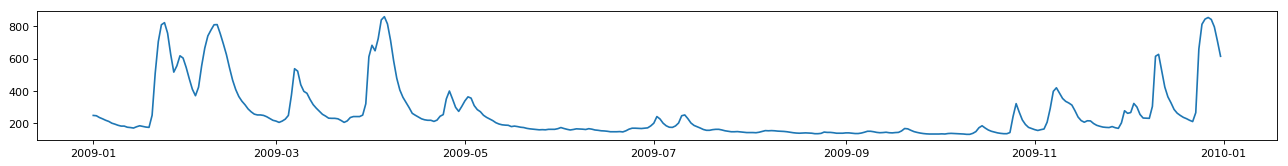

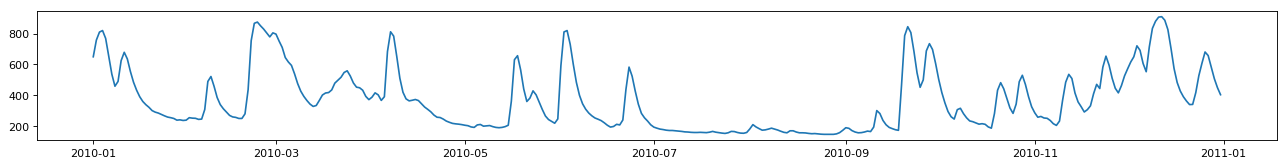

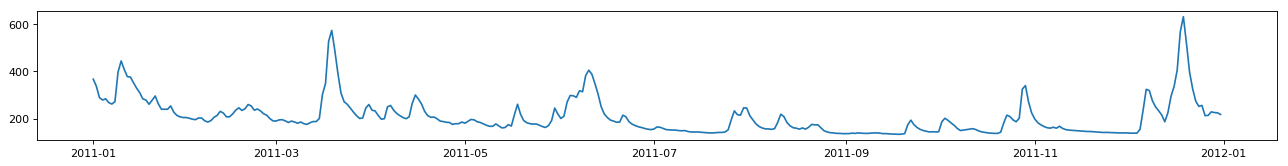

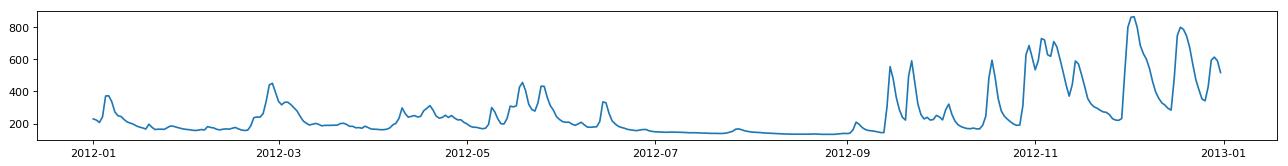

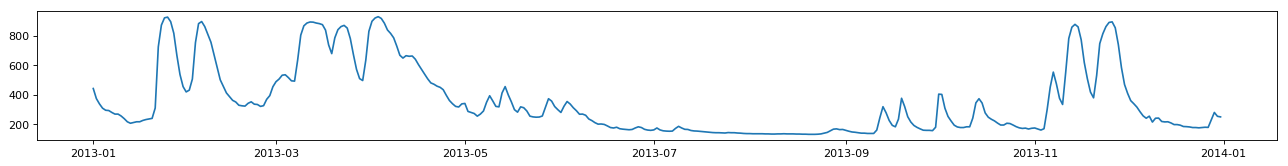

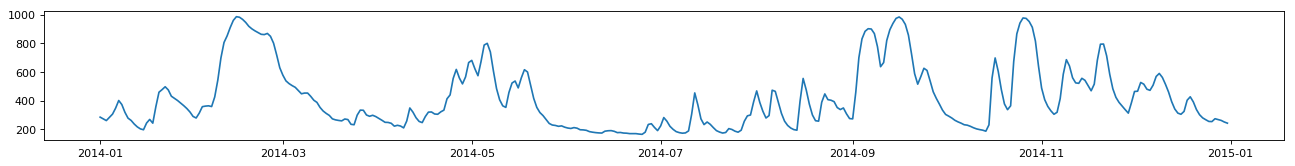

In [7]:
plot_values_through_years(df_water_level, 'Datum', 'Vodostaj')

### Protok

In [8]:
df_flow = pd.read_csv('../Data/Kupa/Flow/FarkasicQ.csv', sep=';')
# convert string date to date type
df_flow['Datum'] = [dt.datetime.strptime(date_str, '%d.%m.%Y') for date_str in df_flow['Datum']]
# create index
df_flow.set_index('Datum')
df_flow.head()

Datum  Protok
0 2009-01-01   126.0
1 2009-01-02   124.0
2 2009-01-03   114.0
3 2009-01-04   106.0
4 2009-01-05    93.5

In [9]:
df_flow.describe()

Protok
count  2191.000000
mean    210.774715
std     234.124743
min      20.200000
25%      53.400000
50%     120.000000
75%     271.000000
max    1239.000000

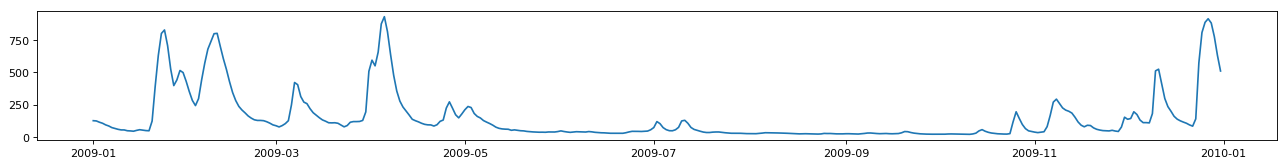

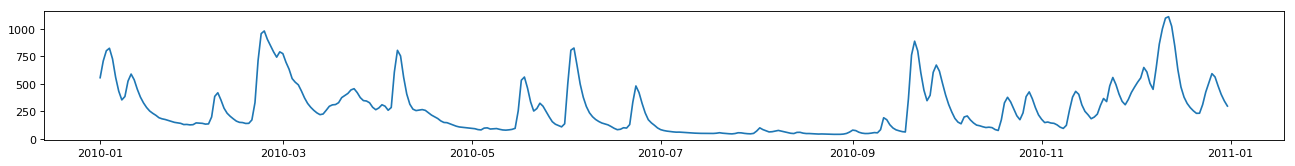

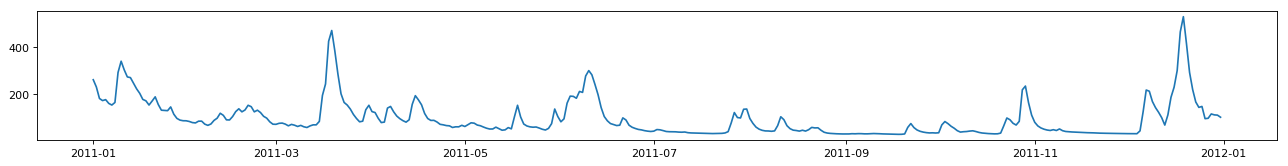

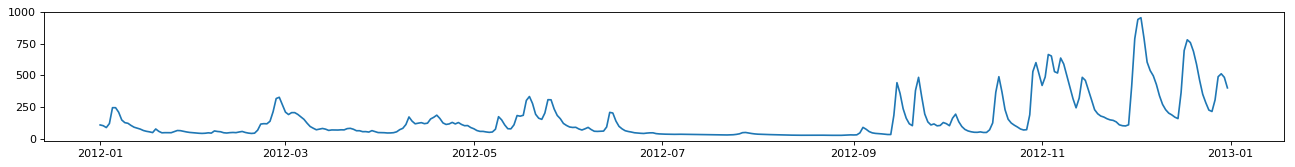

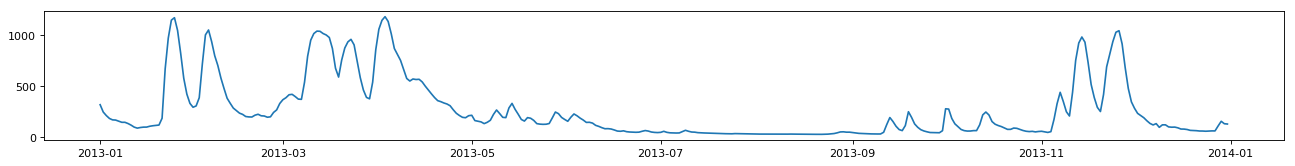

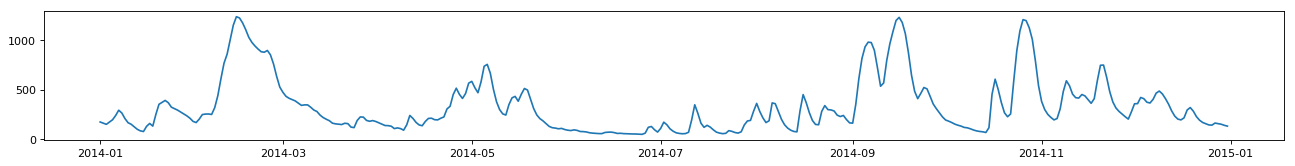

In [10]:
plot_values_through_years(df_flow, 'Datum', 'Protok')

### Padaline

In [11]:
df_rainfall = pd.read_csv('../Data/Kupa/Rainfall/PisarovinaR.csv', sep=';')
# convert string date to date type
df_rainfall['Datum'] = [dt.datetime.strptime(date_str, '%Y-%m-%d') for date_str in df_rainfall['Datum']]
# create index
df_rainfall.set_index('Datum')
df_rainfall.head()

Datum  Padaline
0 2009-01-01       0.0
1 2009-01-02       5.7
2 2009-01-03       0.0
3 2009-01-04       0.0
4 2009-01-05       0.0

In [12]:
df_rainfall.describe()

Padaline
count  2191.000000
mean      2.977545
std       7.305513
min       0.000000
25%       0.000000
50%       0.000000
75%       1.800000
max      82.400000

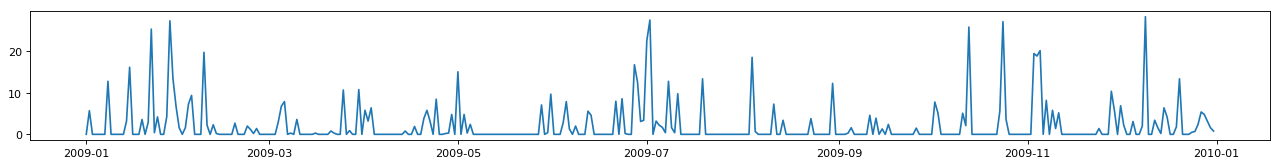

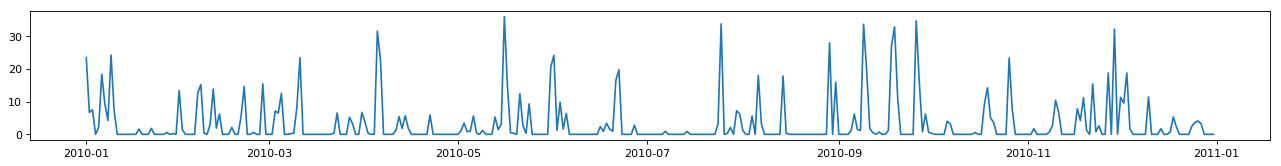

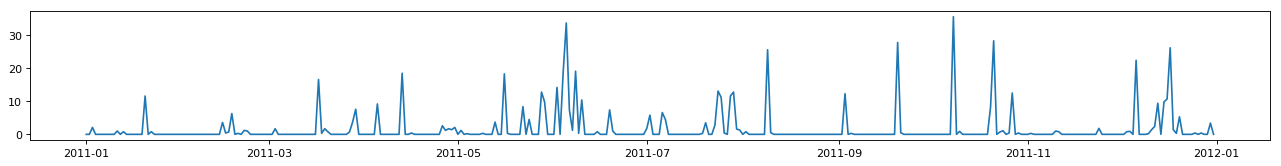

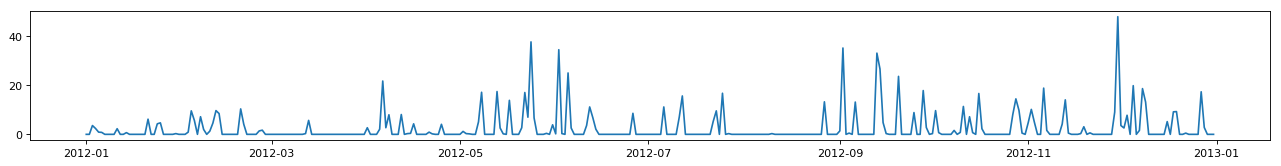

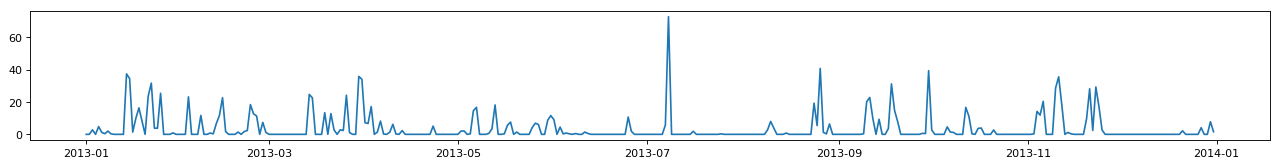

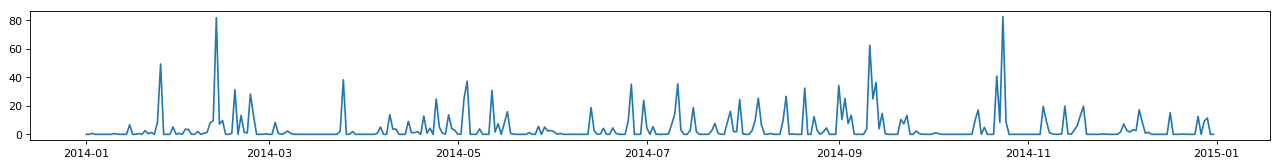

In [13]:
plot_values_through_years(df_rainfall, 'Datum', 'Padaline')

### Izračun koreliranosti vodostaja, protoka i padalina

In [14]:
df_joined = pd.merge(df_water_level, df_flow, left_index=True, right_index=True)
df_joined = pd.merge(df_joined, df_rainfall, left_index=True, right_index=True)
df_joined.corr()

Vodostaj    Protok  Padaline
Vodostaj  1.000000  0.989695  0.169050
Protok    0.989695  1.000000  0.166229
Padaline  0.169050  0.166229  1.000000

### Zaključak
Vodostaj i protok su jako korelirani - kod predviđanja uzeti samo jednu značajku jer je druga redundantna

# Testiranje svojstva stacionarnosti vremenskih serija
Uvjet stacionarnosti: 
- podaci ne ovise o vremenu
- vremenska serija nema trend niti sezonalnost
- izračunate statistike (varijanca, srednja vrijednost) su konstantne kroz vrijeme

## Dickey-Fuller test
- nul-hipoteza: vremenska serija nije stacionarna (posjeduje vremenski ovisnu strukturu)
- alternativna hipoteza: vremenska serija je stacionarna (ne posjeduje vremenski ovisnu strukturu)

**Mogući ishodi:**
- *p-value* > *prag* -> nismo uspjeli odbaciti nul-hipotezu, ne znamo je li vremenska serija stacionarna ili ne
- *p-value* <= *prag* -> uspjeli smo odbaciti nul-hipotezu, prihvaćamo alternativnu hipotezu što znači da je vremenska serija stacionarna

In [18]:
def adfuller_test_report(x):
    """Generates hypothesis test report.
    
    Test report contains:
        ADF Statistic: value1
        p-value: value2
        Critical Values:
            1%: value3
            5%: value4
            10%: value5       

    Parameters
    ----------
    x : array_like, 1d
        time series values
    
    Returns
    -------
    NoneType
        Method does not return nothing
    """
    result = adfuller(x=x, autolag='AIC', regression='c')
    #result = adfuller(x=x, maxlag=366, regression='c')
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Used lag: %f' % result[2])
    print('nObs: %f' % result[3])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

### Vodostaj

In [19]:
water_level = df_water_level["Vodostaj"].values.reshape(-1,)
adfuller_test_report(water_level)

ADF Statistic: -6.450075
p-value: 0.000000
Used lag: 14.000000
nObs: 2176.000000
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


In [20]:
water_level_diff = df_water_level["Vodostaj"].diff(1).dropna().values.reshape(-1,)
adfuller_test_report(water_level_diff)

ADF Statistic: -13.537265
p-value: 0.000000
Used lag: 17.000000
nObs: 2172.000000
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


**Objašnjenje rezultata**
Vidimo da je *ADF Statistic* manji od vrijednosti *Critical Values* uz 1% što znači da možemo odbaciti nul-hipotezu na razini značajnosti 0.01.

### Protok

In [50]:
flow = df_flow["Protok"].values.reshape(-1,)
adfuller_test_report(flow)

ADF Statistic: -6.814828
p-value: 0.000000
Used lag: 14.000000
nObs: 2176.000000
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


### Padaline

In [51]:
rainfall = df_rainfall["Padaline"].values.reshape(-1,)
adfuller_test_report(rainfall)

ADF Statistic: -11.212581
p-value: 0.000000
Used lag: 10.000000
nObs: 2180.000000
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


### Zaključak
Vremenske serije su, prema ADF testu, stacionarne.